<h1 style="font-size:3em; text-align: center">Single-Step Forecasting With Keras LSTM Network</h1>

Our approach here is to develop a Single-Step LSTM RNN which will forecast the next 2 hours of traffic based on the previous 5 hours of data. For computational performance, we lessen the magnitude of data from 5 minute intervals to 15 minute intervals. We used an instructional LSTM example to begin developing the LSTM Neural Network using the Keras library.

Sources:
http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

## Imports Python Libraries

In [127]:
# imports

import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15*0.5, 6*0.5

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

## Assigns a Seed to Ensure reproducable results

In [128]:
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

## Imports a csv data set using Panda

In [129]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*12)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset = dataframe.values
dataset = dataset.astype('float32')

### LSTM-RNN is sensitive to large numbers, so normalizing is a good idea

In [130]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Splits the Original Data into a Training and Testing Set

### train_size and test_size

The calculated length of the training and testing set (respectively) as an integer. The length of the training set is based on the constant 0.67, which means that 2/3 of the original data will be in the training data, and the last third will be to test the LSTM model's accuracy with new data

### train

This dataset contains the first 2/3 of the data available in the original dataset 

### test

This dataset contains the last 1/3 of the data available in the original dataset

In [131]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

## create_dataset()

This function, given a dataset and optionally a look_back variable will generate two matrices. The first will be a matrix with all of the inputs for multiple training sets. The second will be a matrix with the output(s) that the LSTM should have.

<table>
    <tr>
        <th style='text-align: left'>Variables</th>
        <th style='text-align: left'>Description</th>
    </tr>
    <tr>
        <td style='text-align:left'><b>dataset</b></td> 
        <td style='text-align:left'>The dataset which will be split into two input and output matrices</td>
    </tr>
    <tr>
        <td style='text-align:left'><b>look_back</b></td>
        <td style='text-align:left'>(Def = 1) This variable determines how many inputs will be in each row of the input matrix. </td>
    </tr>
</table>

In [132]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

## Uses the Above Function to Create the Training and Test sets

### trainX and testX

A matrix where each row is an array of the input(s) depending on look_back

### trainY and testY

A matrix where each row is an array of the desired output(s)


In [133]:
# reshapes the data into input and output matrices (X and Y respectively)
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## The Data Sets are in the Form [samples, features] so We Reshape to be [samples, time-steps, features]

<b>Samples</b>: Each row, which is a set of all of the inputs
<br/>
<b>Time Steps</b>: The observations that led up to the incident
<br/>
<b>Features</b>: The individual values for the inputs


In [134]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Test Score: 72.82 RMSE


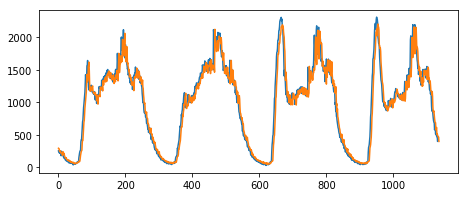

In [135]:
## Optionally, The Model Can Be Fit Multiple Times With the Training Set at the risk of Over-Fitting

# make predictions
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift test predictions for plotting
plt.plot(scaler.inverse_transform(dataset[train_size+look_back*2:]))
plt.plot(testPredict)
plt.show()

## Generates and Trains an LSTM Neural Network with Keras

The model consists of a chain of 4 LSTM Neurons and a Dense layer with an output of 1. The input shape is an matrix with one row and as many features as the look_back variable describes. In other words, this model takes the some number of inputs (depending on look_back) and will return a single output.

The model is then fit using the training set, with a batch_size of 1 and 10 epochs. This fitting process can be repeated but runs the risk of over-fitting the LSTM Network.

In [9]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
27s - loss: 0.0026
Epoch 2/5
25s - loss: 0.0015
Epoch 3/5
26s - loss: 0.0013
Epoch 4/5
26s - loss: 0.0012
Epoch 5/5
26s - loss: 0.0011


In [10]:
for i in range(10):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
25s - loss: 9.7404e-04
Epoch 1/1
26s - loss: 9.0281e-04
Epoch 1/1
25s - loss: 8.1777e-04
Epoch 1/1
26s - loss: 7.9488e-04
Epoch 1/1
25s - loss: 7.5748e-04
Epoch 1/1
24s - loss: 7.4799e-04
Epoch 1/1
23s - loss: 7.3412e-04
Epoch 1/1
25s - loss: 7.4468e-04
Epoch 1/1
25s - loss: 7.3512e-04
Epoch 1/1
25s - loss: 7.1987e-04


## The Model Trained Above is Then Tested using the Testing Dataset


The LSTM model is given the testX and the LSTM attempts to predict the next value. The accuracy of the model is calculated using the Root Mean Squared Error (RMSE) and is displayed. The model's predictions are then graphed ontop of the actual data to visually show the accuracy of the model.


Train Score: 67.71 RMSE
Test Score: 72.82 RMSE


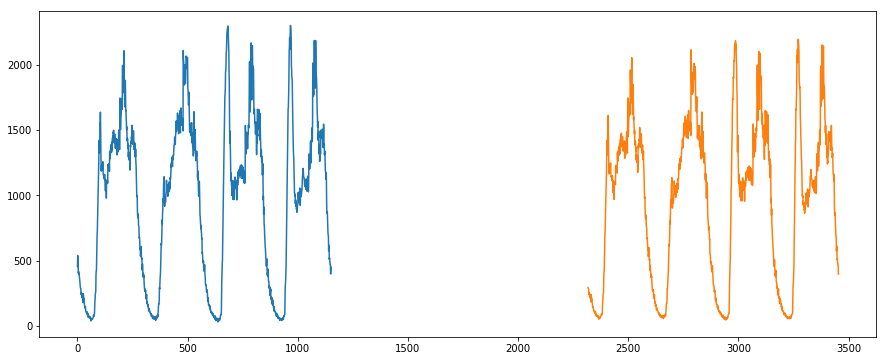

In [39]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<h1 style="font-size:3em; text-align: center">Making The LSTM-RNN Fit The Original Data</h1>

At first, I renamed many of the variables from the above to distinguish between the separate cases. However, I decided it more efficient to generalize the LSTM-RNN into a function for simpification

## Seeding for Reproducable Results

In [ ]:
np.random.seed(69)

## Loads the Original Data Set, and Prepares Them for the Neural Network

In [19]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '15min'

# load the dataset
car_dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=2000)
car_dataframe['time_bucket'] = pd.to_datetime(car_dataframe['time_bucket'])
car_dataframe = car_dataframe.set_index('time_bucket')
car_dataframe['total'] = car_dataframe.sum(axis=1)
car_dataframe['day_hour'] = car_dataframe.index.round(time_grouping)

# datasets for two districts in particular
car_dataframe_station_1 = car_dataframe[['1afd7afbc81ecc1b13886a569d869e8a', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_1 = car_dataframe_station_1.values
car_dataset_station_1 = car_dataset_station_1.astype('float32')

car_dataframe_station_2 = car_dataframe[['d4ec2125aff74eded207d2d915ef682f', 'day_hour']].groupby('day_hour').sum();
car_dataset_station_2 = car_dataframe_station_2.values
car_dataset_station_2 = car_dataset_station_2.astype('float32')

# The data set with the sum of all the cars out at the 
car_dataframe = car_dataframe[['total','day_hour']].groupby('day_hour').sum()

car_dataset = car_dataframe.values
car_dataset = car_dataset.astype('float32')

## Generalized the Above Described Process to Work With Most Datasets

In [ ]:
def trainAndPredict(dataset, look_back=1, num_epochs=100):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=num_epochs, batch_size=1, verbose=2)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    return model


In [ ]:
np.random.seed(69)
training_model = trainAndPredict(car_dataset, look_back=20, num_epochs=5)

In [ ]:
np.random.seed(69)
trainAndPredict(car_dataset_station_1, look_back=20, num_epochs=5)

In [ ]:
np.random.seed(69)
trainAndPredict(car_dataset_station_2, look_back=20, num_epochs=5)

# The Prediction Function

This function uses a given trained LSTM model and data to implements a recursive forecasting method, where the output of the previous forecast is then fed into the next, as shown below.
<pre>
prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))
prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))
</pre>
The function then returns a 1-D array with the forecasted values for the next two hours, estimating a value every 15 minutes

<table> 
  <tr>
    <th>Variables</th>
    <th>Description</th>
  </tr>
  <tr>
    <td style="text-align:left"><b>model </b></td>
    <td style="text-align:left"> The Keras Model that has been previously trained </td>
  </tr>
  <tr>
    <td style="text-align:left"><b>data </b></td>
    <td style="text-align:left"> A 2-D NumPy Array with data for the previous times in the first row </td>
  </tr>
  <tr>
    <td style="text-align:left"><b>time_group (opt) </b></td>
    <td style="text-align:left"> (def = <i>time_grouping</i>) the time grouping for the valies  </td>
  </tr>
</table>

<br/>
<b>@returns</b> - 1-D array for the expected next two hours

In [ ]:
def predictNext2Hours (model, dataset, time_group=time_grouping):
    dataset.astype('float32')
    predictions = []
    
    # for as many times as it takes until the number of predictions x time_group >= 2 hours
    for i in range(20):
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = dataset.transpose()
        dataset = scaler.fit_transform(dataset)
        dataset = dataset.transpose()
        
        # reshape the dataset
        data = dataset.T
        data = data.reshape(1, 1, data.shape[0])
        
        # make a prediction
        prediction = model.predict(data)
        
        # take out the first element, add the prediction to the end
        dataset[0][0:len(dataset[0])-1] = dataset[0][ 1: len(dataset[0])]
        dataset[0, len(dataset[0])-1] = prediction
        
        # un-normalize the data set
        dataset = dataset.transpose()
        dataset = scaler.inverse_transform(dataset)
        dataset = dataset.transpose()
        # push the prediction into the array of predictions
        predictions.append(dataset[0, len(dataset[0])-1])
        
        # repeat
    
    return np.array(predictions)

## We Attempt the Recusive Forecasting with the Model

We provide a sample of the real data and graph the resulting one dimensional array onto of the true data ontop of it

In [ ]:
pred = predictNext2Hours (training_model, np.array([[2494,2024,1697,1408,1117,913,794,621,535,400,372,332,300,247,180,167,182,207,251,474]]))
plt.plot(actu[:,0])
plt.plot(pred, color="red")
plt.show()

testScore = math.sqrt(mean_squared_error(actu[:,0], pred))
print('%.2f RMSE' % (testScore))
